## Seleção de Regiões com Maior Margem de Lucro

Possuímos informações sobre as reservas de petróleo em três regiões distintas, sendo que para cada região temos um conjunto de dados específico. O objetivo é utilizar modelos de Regressão Linear para treinar cada um desses conjuntos de dados, a fim de prever o volume de petróleo que cada região conterá. Com base nessas previsões, iremos calcular as receitas geradas em cada região e, por fim, decidir qual delas possui a maior margem de lucro.

## Sumário


1. [Iniciação](#inic)

2. [Separação de Dados e Treinamento de Modelos](#sdtm)

3. [Volume de Equilíbrio por Poço](#vepp)

4. [Lucro de Poços Selecionados e Previsões de Modelos](#lppm)

5. [Risco e Lucro por Região](#rlr)

6. [Conclusão](#co)

## Iniciação <a id="inic"></a>

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt

In [2]:
try:
    data_0 = pd.read_csv('geo_data_0.csv')
    data_1 = pd.read_csv('geo_data_1.csv')
    data_2 = pd.read_csv('geo_data_2.csv')
except:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
data_0.info()
data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data_1.info()
data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
data_2.info()
data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Após examinar os conjuntos de dados, constatamos que não há valores ausentes, o que é bastante positivo. O objetivo será sempre a coluna `product`, enquanto as demais colunas serão consideradas como `características` (features).

### Separação de Dados e Treinamento de Modelos <a id="sdtm"></a>

Uma forma de começar é criando uma função que recebe quatro conjuntos de dados como parâmetros: as `características` e o `alvo de treinamento`, bem como as `características` e o `alvo de validação`. Essa função treinará um modelo de `Regressão Linear` utilizando os dados de treinamento e retornará o `erro quadrático médio` (RMSE) e as previsões geradas pelo modelo. Em seguida, para cada conjunto de dados, realizaremos a divisão dos dados de forma adequada e chamaremos a função definida anteriormente para treinar um modelo. Implementaremos a função:

In [6]:
def lr_model(f_train, f_valid, t_train, t_valid):
    lr = LinearRegression().fit(f_train, t_train)
    t_pred = lr.predict(f_valid)
    rmse = (mean_squared_error(t_valid, t_pred)) ** 0.5
    return rmse, t_pred

Agora podemos realizar a divisão dos dados (`75%` para treinamento e `25%` para validação). A coluna `id` em cada conjunto de dados é única para cada reserva, então ela não será útil no processo de aprendizado, e por isso iremos removê-la. Em seguida, treinaremos modelos para cada conjunto de dados, passando as quatro divisões como argumentos para a nossa função `lr_model`. Podemos obter o `erro quadrático médio` (RMSE) e a média das previsões. Para a `região 0`:

In [7]:
features0 = data_0.drop(['id', 'product'], axis=1)
target0 = data_0['product']
f_train0, f_valid0, t_train0, t_valid0 = train_test_split(features0, target0, test_size=0.25, \
                                                          random_state=12345)
rmse0, pred0 = lr_model(f_train0, f_valid0, t_train0, t_valid0)
print('RMSE:', rmse0, '; Average predicted volume:', pred0.mean())

RMSE: 37.5794217150813 ; Average predicted volume: 92.59256778438035


Para a `região 0`, o RMSE é de `37.58` e a média das previsões é `92,59`.

Região 1:

In [8]:
features1 = data_1.drop(['id', 'product'], axis=1)
target1 = data_1['product']
f_train1, f_valid1, t_train1, t_valid1 = train_test_split(features1, target1, test_size=0.25, \
                                                          random_state=12345)
rmse1, pred1 = lr_model(f_train1, f_valid1, t_train1, t_valid1)
print('RMSE:', rmse1, '; Average predicted volume:', pred1.mean())

RMSE: 0.8930992867756168 ; Average predicted volume: 68.72854689544602


Para a `região 1`, o RMSE é de `0.89` e a média das previsões é `68,73`.

Região 2:

In [9]:
features2 = data_2.drop(['id', 'product'], axis=1)
target2 = data_2['product']
f_train2, f_valid2, t_train2, t_valid2 = train_test_split(features2, target2, test_size=0.25, \
                                                          random_state=12345)
rmse2, pred2 = lr_model(f_train2, f_valid2, t_train2, t_valid2)
print('RMSE:', rmse2, '; Average predicted volume:', pred2.mean())

RMSE: 40.02970873393434 ; Average predicted volume: 94.96504596800489


Para a `região 0`, o RMSE é de `40,03` e a média das previsões é de `94,96`. Pelo RMSE, o modelo desta região foi o mais preciso, pois apresenta o menor valor de RMSE. No entanto, a região 3 teve a maior média das previsões.

### Volume de Equilíbrio por Poço <a id="vepp"></a>

Informações:

- o orçamento para o desenvolvimento de `200` poços de petróleo é de `100 milhões` de dólares

- ao explorar a região, é feito um estudo de `500` pontos com a escolha dos `200` melhores pontos para o cálculo do lucro

- a receita de uma unidade de produto é de `4.500` dólares

Armazenaremos essas informações em variáveis (elas também serão úteis durante o cálculo do lucro). Para determinar o volume necessário para viabilizar o desenvolvimento de um novo poço sem prejuízos, é necessário calcular o custo de desenvolvimento do poço e dividir esse valor pela receita obtida por volume.

In [10]:
points = 500
points_needed = 200
budget_200 = 100000000
income_per_volume = 4500
well_cost = budget_200/points_needed
no_loss_volume = well_cost/income_per_volume
print(no_loss_volume)

111.11111111111111


O resultado é 111,11 unidades de produto. Comparando o mesmo com as médias das 3 regiões:

In [11]:
print('Produção média da região 0:', data_0['product'].mean())
print('Produção média da região 1:', data_1['product'].mean())
print('Produção média da região 2:', data_2['product'].mean())

Produção média da região 0: 92.49999999999974
Produção média da região 1: 68.82500000002561
Produção média da região 2: 95.00000000000041


Todos esses volumes estão abaixo do ponto de equilíbrio, o que significa que, em média, todas as regiões estão tendo prejuízos.

### Lucro de Poços Selecionados e Previsões de Modelos <a id="lppm"></a>

Informações:

- Escolher os poços com os maiores valores de previsões

- Resumir o volume alvo de reservas de acordo com essas previsões

Escreveremos, portanto, a função que receberá o `alvo`, as `previsões` e o `número de poços` como argumentos para calcular o `lucro`:

In [12]:
def revenue(target, predicted, n):
    predicted = pd.Series(predicted)
    target = target.reset_index(drop=True)
    indices = predicted.sort_values(ascending=False).index 
    return (target.loc[indices][:n].sum() * income_per_volume) - (well_cost * n)

### Risco e Lucro por Região <a id="rlr"></a>

Utilizaremos a técnica de bootstrap para criar amostras (1000 neste caso) do alvo e associá-las aos respectivos valores de previsão. A partir dessas amostras, calcularemos o lucro para os 200 poços com as previsões mais rentáveis em cada amostra, armazenando todos os valores de lucro em uma lista. É importante destacar que, durante a exploração da região, um estudo é realizado com 500 pontos, selecionando os 200 pontos de maior lucratividade para o cálculo do lucro.

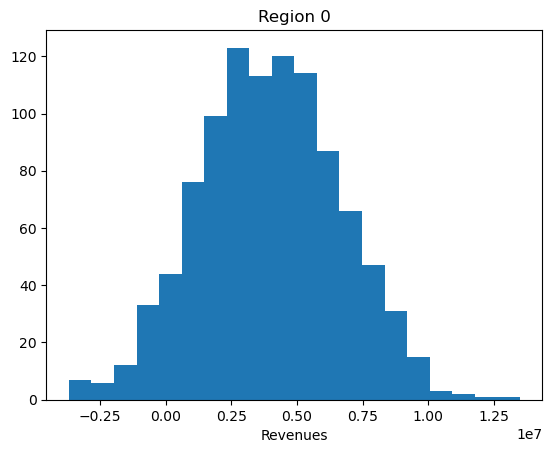

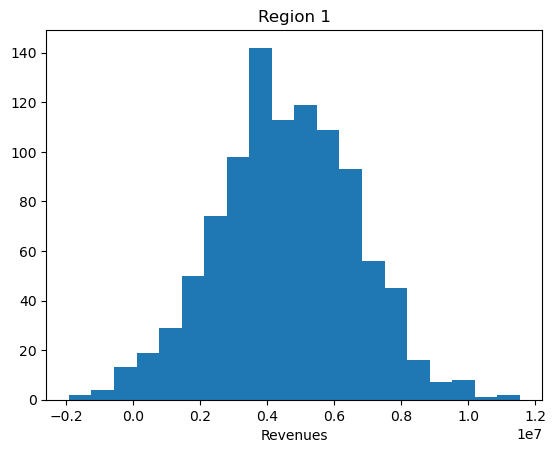

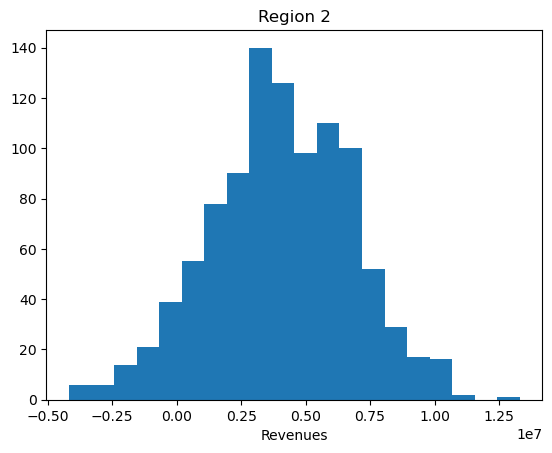

In [13]:
def rev_bootstr(target, predictions):
    state = np.random.RandomState(12345)
    values = []
    target = target.reset_index(drop=True)
    
    for i in range(1000):
        target_sample = target.sample(n=points, replace=True, random_state=state)
        pred_sample = predictions[target_sample.index]
        values.append(revenue(target_sample, pred_sample, points_needed))
    return pd.Series(values)

revenues0 = rev_bootstr(t_valid0, pred0)
revenues1 = rev_bootstr(t_valid1, pred1)
revenues2 = rev_bootstr(t_valid2, pred2)

plots = [revenues0, revenues1, revenues2]
titles = ['Region 0', 'Region 1', 'Region 2']

for i in range(3):
    plt.hist(plots[i], bins=20)
    plt.title(titles[i])
    plt.xlabel('Revenues')
    plt.show()

Podemos observar que, de modo geral, todas as regiões são lucrativas, embora algumas perdas sejam observadas. Para cada região, é possível calcular o intervalo de confiança de `95%`, a média e o risco de perda em porcentagem. Desejamos que a região tenha um risco de perda inferior a `2,5%`. Primeiramente, a `região 0`:

In [14]:
conf_interval = [revenues0.quantile(0.025), revenues0.quantile(0.975)]
loss_risk = len(revenues0[revenues0 < 0]) / len(revenues0)

print('Região 0')
print('Lucro médio', revenues0.mean()) 
print('Intervalo de confiança de 95%:', conf_interval)
print('Risk of losses', loss_risk)

Região 0
Lucro médio 3961649.84802371
Intervalo de confiança de 95%: [-1112155.4589049604, 9097669.41553423]
Risk of losses 0.069


Para a `região 1`:

In [15]:
conf_interval = [revenues1.quantile(0.025), revenues1.quantile(0.975)]
loss_risk = len(revenues1[revenues1 < 0]) / len(revenues1)

print('Região 1')
print('Lucro médio', revenues1.mean()) 
print('Intervalo de confiança de 95%:', conf_interval)
print('Risco de perdas', loss_risk)

Região 1
Lucro médio 4560451.057866613
Intervalo de confiança de 95%: [338205.0939898458, 8522894.538660347]
Risco de perdas 0.015


Para a `região 2`:

In [16]:
conf_interval = [revenues2.quantile(0.025), revenues2.quantile(0.975)]
loss_risk = len(revenues2[revenues2 < 0]) / len(revenues2)

print('Região 2')
print('Lucro médio', revenues2.mean()) 
print('Intervalo de confiança de 95%:', conf_interval)
print('Risco de perdas', loss_risk)

Região 2
Lucro médio 4044038.665683569
Intervalo de confiança de 95%: [-1633504.1339559986, 9503595.749237997]
Risco de perdas 0.076


Concluímos que a `Região 1` é a mais adequada para o desenvolvimento de petróleo, pois possui o menor risco de prejuízo (`1,5%`), os maiores limites de intervalo de confiança de 95% (Limite inferior: `4.431.472,49`; Limite superior: `4.689.429,63`) e o maior lucro médio de `4.560.451,06`.

### Conclusão <a id="co"></a>

Foi realizado um treinamento de modelos de `Regressão Linear` para os conjuntos de dados das três regiões. Durante o processo, estabelecemos que um volume de `111,11` unidades é necessário para evitar qualquer prejuízo em um poço.

Em seguida, aplicamos a técnica de `bootstrap` para criar amostras com `500` valores do alvo, utilizando as respectivas previsões correspondentes para calcular os valores de lucro das `200` reservas mais rentáveis em cada amostra. Com base nessas amostras, calculamos intervalos de confiança de `95%`, `média de lucro` e `risco de perda`.

Após a análise dos resultados, conclui-se que a `Região 1` é a mais adequada para o desenvolvimento de petróleo. Essa região apresenta o menor risco de perda, com apenas `1,5%` de probabilidade de prejuízo. Além disso, possui os maiores limites de intervalo de confiança (Limite inferior: `4.431.472,49`; Limite superior: `4.689.429,63`) e o maior lucro médio de aproximadamente `4.560.451,06`.

Essas descobertas indicam que a `Região 1` oferece as melhores condições para o desenvolvimento de poços de petróleo com maior probabilidade de lucratividade e menor risco de prejuízo.